# **Gen-AI Project**

## **Group Members**

### 1. Ankit Kumar (251110012)
### 2. Arpit Yadav (251110015)
### 3. Shrey Sharma (251110068)
### 4. Anuj Singh (251110403)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE = "/content/drive/MyDrive/genai-project-final/gen-ai-final-project-sub"

# KD on VGG16

In [ ]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):

        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_vgg_teacher(num_classes=10):
    inputs = keras.Input(shape=(32, 32, 3), name="cifar_input")
    x = layers.Resizing(224, 224, interpolation="bilinear", name="resize_224")(inputs)
    x = layers.Lambda(lambda z: z * 255.0, name="to_255")(x)
    x = layers.Lambda(keras.applications.vgg16.preprocess_input, name="vgg16_pre")(x)
    vgg = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    vgg.trainable = False
    x = vgg(x)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    outputs = layers.Dense(num_classes, name="logits")(x)
    return keras.Model(inputs, outputs, name="vgg16_teacher")


student = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),

        layers.Conv2D(16, 3, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.MaxPooling2D(pool_size=2, strides=2, padding="same"),


        layers.Conv2D(32, 3, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.MaxPooling2D(pool_size=2, strides=2, padding="same"),


        layers.Conv2D(64, 3, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.MaxPooling2D(pool_size=2, strides=2, padding="same"),


        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10),
    ],
    name="student",
)


teacher = build_vgg_teacher(num_classes=10)
teacher.summary()

student_scratch = keras.models.clone_model(student)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16_teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cifar_input (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize_224 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ to_255 (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_pre (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,074 (609.66 KB)

 Trainable params: 156,074 (609.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow import keras
import numpy as np

batch_size = 64
PCT_PER_CLASS = 0.30
SEED = 42


(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0


y_train = y_train.squeeze()
y_test  = y_test.squeeze()

def stratified_subset(x, y, pct=0.30, seed=42):
    rng = np.random.default_rng(seed)
    xs, ys = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        n_keep = max(1, int(round(len(idx) * pct)))
        sel = rng.choice(idx, size=n_keep, replace=False)
        xs.append(x[sel])
        ys.append(y[sel])
    x_sub = np.concatenate(xs, axis=0)
    y_sub = np.concatenate(ys, axis=0)
    perm = rng.permutation(len(y_sub))
    return x_sub[perm], y_sub[perm]

x_train, y_train = stratified_subset(x_train, y_train, PCT_PER_CLASS, SEED)
x_test,  y_test  = stratified_subset(x_test,  y_test,  PCT_PER_CLASS, SEED)

print("Train subset:", x_train.shape, y_train.shape)
print("Test  subset:", x_test.shape,  y_test.shape)
print("Classes in train:", np.unique(y_train))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train subset: (15000, 32, 32, 3) (15000,)
Test  subset: (3000, 32, 32, 3) (3000,)
Classes in train: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# teacher.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )

# teacher.fit(x_train, y_train, epochs=20)
# teacher.evaluate(x_test, y_test)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 203ms/step - loss: 1.8596 - sparse_categorical_accuracy: 0.4854
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - loss: 0.5957 - sparse_categorical_accuracy: 0.7975
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - loss: 0.4822 - sparse_categorical_accuracy: 0.8362
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - loss: 0.4148 - sparse_categorical_accuracy: 0.8556
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.8669
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 178ms/step - loss: 0.3570 - sparse_categorical_accuracy: 0.8764
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - loss: 0.3477 - sparse_categorical_accuracy: 0.8821
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - loss: 0.3277 - sparse_categorical_accuracy: 0.8907
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 178ms/step - loss: 0.3145 - sparse_categorical_accuracy: 0.8929
Epoch 10/20
469/469 ━━━━━

[0.5831578969955444, 0.8326666951179504]

In [ ]:
# distiller = Distiller(student=student, teacher=teacher)
# distiller.compile(
#     optimizer=keras.optimizers.Adam(),
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
#     student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     distillation_loss_fn=keras.losses.KLDivergence(),
#     alpha=0.1,
#     temperature=10,
# )

# distiller.fit(x_train, y_train, epochs=20)

# distiller.evaluate(x_test, y_test)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 9.2812 - sparse_categorical_accuracy: 0.1347
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - loss: 1.3910 - sparse_categorical_accuracy: 0.2083
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 183ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.3377
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - loss: 0.3915 - sparse_categorical_accuracy: 0.4315
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - loss: 0.2783 - sparse_categorical_accuracy: 0.4678
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 182ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.4968
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - loss: 0.2057 - sparse_categorical_accuracy: 0.5258
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - loss: 0.1959 - sparse_categorical_accuracy: 0.5540
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - loss: 0.1901 - sparse_categorical_accuracy: 0.5764
Epoch 10/20
469/469 ━━━━━━━

[0.19525036215782166, 0.6613333225250244]

In [ ]:
# student_path = os.path.join(BASE, "student_distilled.keras")
# student.save(student_path)

# print(f"Student model saved successfully at {student_path}")

Student model saved successfully at /content/drive/MyDrive/genai-project-final/gen-ai-final-project-sub/student_distilled.keras


# **Used this STUDENT MODEL in base paper(Show and Tell) CNN(VGG16) +LSTM**

In [ ]:
!nvidia-smi -L || echo "No GPU?"
!python -V
!pip -q install datasets pillow nltk einops

GPU 0: Tesla T4 (UUID: GPU-5a0eb01b-0d32-b413-12fc-b0b439dda1fa)
Python 3.12.12


In [ ]:
!pip install tqdm
from tqdm import tqdm

In [ ]:
import os, math, random, re
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from collections import defaultdict, Counter

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as KL
from tensorflow.keras import Model

from datasets import load_dataset
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt', quiet=True)

# Repro
SEED = 1337
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

@dataclass
class CFG:
    dataset_name: str = "tsystems/flickr8k"  # alt: "jxie/flickr8k"
    encoder_name: str = "student"              # "vgg16", "resnet50", "inceptionv3", "efficientnetb0"
    rnn_type: str = "lstm"                   # "lstm", "gru", "rnn"
    embedding_dim: int = 256
    rnn_units: int = 512
    dropout: float = 0.3
    max_len: int = 20        # generated length (excl <start>)
    vocab_size: int = 9000
    min_freq: int = 1
    batch_size: int = 64
    epochs: int = 15
    lr: float = 3e-4
    clipnorm: float = 5.0
    val_split: float = 0.1
    test_split: float = 0.1
    beam_size: int = 3

    def image_size(self):
        return (299, 299) if self.encoder_name.lower() == "inceptionv3" else (224, 224)

CFG = CFG()

PAD_TOKEN = "<pad>"
START_TOKEN = "<start>"
END_TOKEN = "<end>"
UNK_TOKEN = "<unk>"


In [ ]:
print("Loading HF dataset:", CFG.dataset_name)
raw_ds = load_dataset(CFG.dataset_name)
ds_all = raw_ds["train"] if "train" in raw_ds else raw_ds[list(raw_ds.keys())[0]]
print(ds_all)

if "image_filename" in ds_all.column_names:
    img_ids = [fn for fn in ds_all["image_filename"]]
else:
    img_ids = [f"img_{i:05d}" for i in range(len(ds_all))]

assert "captions" in ds_all.column_names, "Dataset must have column 'captions'"
captions_list = ds_all["captions"]

img2caps = defaultdict(list)
for iid, caps in zip(img_ids, captions_list):
    img2caps[iid].extend(caps if isinstance(caps, list) else [caps])

unique_img_ids = list(img2caps.keys())
random.shuffle(unique_img_ids)
N = len(unique_img_ids)
val_n = int(CFG.val_split * N)
test_n = int(CFG.test_split * N)
train_ids = unique_img_ids[: N - val_n - test_n]
val_ids   = unique_img_ids[N - val_n - test_n : N - test_n]
test_ids  = unique_img_ids[N - test_n :]

print(f"Total images: {N} | train: {len(train_ids)}, val: {len(val_ids)}, test: {len(test_ids)}")

def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9\s'.,!?]", "", s)
    s = re.sub(r"\s+", " ", s)
    return s

all_train_caps = []
for iid in train_ids:
    for c in img2caps[iid]:
        all_train_caps.append(normalize_text(c))

word_counts = Counter()
for sent in all_train_caps:
    word_counts.update(sent.split())

vocab = [w for w,c in word_counts.items() if c >= CFG.min_freq]
vocab = sorted(vocab, key=lambda w: (-word_counts[w], w))
vocab = [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN] + vocab
if len(vocab) > CFG.vocab_size:
    vocab = vocab[:CFG.vocab_size]

word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}
print("Vocab size:", len(vocab))

def encode_caption(text: str) -> List[int]:
    ids = [word2idx.get(tok, word2idx[UNK_TOKEN]) for tok in normalize_text(text).split()]
    return [word2idx[START_TOKEN]] + ids + [word2idx[END_TOKEN]]

max_cap_len = min(max(len(encode_caption(c)) for c in all_train_caps), CFG.max_len + 2)
print("Max caption length used:", max_cap_len)


Loading HF dataset: tsystems/flickr8k


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/492 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8091 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_filename', 'captions', 'query'],
    num_rows: 8091
})
Total images: 8091 | train: 6473, val: 809, test: 809
Vocab size: 8036
Max caption length used: 22


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
student = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),

        layers.Conv2D(16, 3, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.MaxPooling2D(pool_size=2, strides=2, padding="same"),


        layers.Conv2D(32, 3, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.MaxPooling2D(pool_size=2, strides=2, padding="same"),


        layers.Conv2D(64, 3, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.MaxPooling2D(pool_size=2, strides=2, padding="same"),


        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10),
    ],
    name="student",
)

student_scratch = keras.models.clone_model(student)

In [ ]:
import tensorflow as tf
from tensorflow import keras

STUDENT_PATH = f"{BASE}/student_distilled.keras"

student_model = tf.keras.models.load_model(STUDENT_PATH)
student_model.summary()


Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,074 (609.66 KB)

 Trainable params: 156,074 (609.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
IMG_H, IMG_W = CFG.image_size()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def get_encoder_and_preproc(name: str):
    name = name.lower()
    IMG_H, IMG_W = CFG.image_size()
    gap = tf.keras.layers.GlobalAveragePooling2D()

    if name in ("vgg", "vgg16"):
        base = tf.keras.applications.VGG16(
            include_top=False, weights="imagenet", input_shape=(IMG_H, IMG_W, 3)
        )
        base.trainable = False
        preprocess = tf.keras.applications.vgg16.preprocess_input  # expects 0–255 RGB
        return base, gap, preprocess

    elif name == "student":

        student = tf.keras.models.load_model(STUDENT_PATH, compile=False)
        student.trainable = False


        sH = sW = None
        for lyr in student.layers:
            if hasattr(lyr, "input_shape") and isinstance(lyr.input_shape, (tuple, list)):
                shp = lyr.input_shape
                if isinstance(shp, list):
                    shp = shp[0]
                if shp and len(shp) == 4:
                    sH, sW = shp[1], shp[2]
                    break

        if sH is None or sW is None:
            sH, sW = 32, 32

        enc_inp = keras.Input(shape=(IMG_H, IMG_W, 3), name="student_enc_input")
        x = enc_inp
        if (IMG_H, IMG_W) != (sH, sW):
            x = layers.Resizing(sH, sW, interpolation="bilinear", name="student_resize")(x)


        _ = student(tf.zeros((1, sH, sW, 3), dtype=tf.float32))


        last_conv = None
        for lyr in reversed(student.layers):
            if isinstance(lyr, layers.Conv2D):
                last_conv = lyr
                break
        if last_conv is None:
            raise ValueError("No Conv2D layer found in the student model.")


        conv_feat_model = keras.Model(inputs=student.inputs, outputs=last_conv.output, name="student_conv_feat")

        conv_feats = conv_feat_model(x)

        encoder = keras.Model(enc_inp, conv_feats, name="student_encoder")
        encoder.trainable = False


        def preprocess(img):
            img = tf.cast(img, tf.float32)
            return img / 255.0

        return encoder, gap, preprocess

    else:
        raise ValueError(f"Unknown encoder name: {name}")


ENCODER_BASE, ENCODER_GAP, PREPROC = get_encoder_and_preproc(CFG.encoder_name)


In [ ]:
all_images = ds_all["image"]

def pil_to_tensor(img: Image.Image) -> tf.Tensor:
    arr = np.array(img.convert("RGB"))
    return tf.convert_to_tensor(arr, dtype=tf.float32)

train_pairs, val_pairs, test_pairs = [], [], []
for idx, iid in enumerate(img_ids):
    caps = img2caps[iid]
    target = train_pairs if iid in train_ids else (val_pairs if iid in val_ids else (test_pairs if iid in test_ids else None))
    if target is not None:
        for c in caps:
            target.append((idx, c))
print(f"Train pairs: {len(train_pairs)} | Val pairs: {len(val_pairs)} | Test pairs: {len(test_pairs)}")

def tf_encode_and_resize(image_tensor: tf.Tensor) -> tf.Tensor:
    return tf.image.resize(image_tensor, (IMG_H, IMG_W))

def _preprocess_example(idx: tf.Tensor, caption: tf.Tensor):
    img_pil = all_images[int(idx.numpy())]
    img = pil_to_tensor(img_pil)
    img = tf_encode_and_resize(img)
    img = PREPROC(img)
    cap_text = caption.numpy().decode("utf-8")
    cap_ids = encode_caption(cap_text)
    cap_ids = cap_ids[:max_cap_len]
    cap_ids += [word2idx[PAD_TOKEN]] * (max_cap_len - len(cap_ids))
    return img, np.array(cap_ids, dtype=np.int32)

def tf_preprocess(idx, caption):
    img, cap = tf.py_function(func=_preprocess_example, inp=[idx, caption], Tout=[tf.float32, tf.int32])
    img.set_shape((IMG_H, IMG_W, 3))
    cap.set_shape((max_cap_len,))
    return img, cap

def make_dataset(pairs, shuffle=True):
    idxs = [p[0] for p in pairs]
    caps = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((idxs, caps))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(CFG.batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_pairs, shuffle=True)
val_ds   = make_dataset(val_pairs, shuffle=False)


Train pairs: 32365 | Val pairs: 4045 | Test pairs: 4045


In [ ]:
def build_decoder(rnn_type: str, rnn_units: int, dropout: float):
    rnn_type = rnn_type.lower()
    if rnn_type == "lstm":
        return KL.LSTM(rnn_units, return_sequences=True, return_state=True, dropout=dropout)
    if rnn_type == "gru":
        return KL.GRU(rnn_units, return_sequences=True, return_state=True, dropout=dropout)
    if rnn_type == "rnn":
        return KL.SimpleRNN(rnn_units, return_sequences=True, return_state=True, dropout=dropout)
    raise ValueError("Unknown rnn_type")

class ShowAndTell(Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, rnn_type, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = KL.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.cnn = ENCODER_BASE
        self.gap = ENCODER_GAP
        self.img_proj = KL.Dense(rnn_units, activation="relu")
        self.init_h = KL.Dense(rnn_units)
        self.init_c = KL.Dense(rnn_units)
        self.rnn_type = rnn_type.lower()
        self.rnn = build_decoder(rnn_type, rnn_units, dropout)
        self.dropout = KL.Dropout(dropout)
        self.classifier = KL.Dense(vocab_size)

    def _encode_image(self, x_img):
        x = self.cnn(x_img, training=False)
        x = self.gap(x)
        x = self.img_proj(x)
        return x

    def call(self, inputs, training=False):
        images, token_ids = inputs
        img_embed = self._encode_image(images)
        if self.rnn_type == "lstm":
            h0 = self.init_h(img_embed)
            c0 = self.init_c(img_embed)
            initial_state = [h0, c0]
        else:
            h0 = self.init_h(img_embed)
            initial_state = [h0]
        x = self.embedding(token_ids[:, :-1])
        x = self.dropout(x, training=training)
        rnn_out, *states = self.rnn(x, initial_state=initial_state, training=training)
        logits = self.classifier(rnn_out)
        return logits

model = ShowAndTell(
    vocab_size=len(vocab),
    embedding_dim=CFG.embedding_dim,
    rnn_units=CFG.rnn_units,
    rnn_type=CFG.rnn_type,
    dropout=CFG.dropout
)


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam(learning_rate=CFG.lr)
PAD_ID = word2idx[PAD_TOKEN]

@tf.function
def train_step(images, captions):
    targets = captions[:, 1:]
    with tf.GradientTape() as tape:
        logits = model((images, captions), training=True)
        mask = tf.cast(tf.not_equal(targets, PAD_ID), tf.float32)
        loss = loss_fn(targets, logits)
        loss = tf.reduce_sum(loss * mask) / (tf.reduce_sum(mask) + 1e-8)
    grads = tape.gradient(loss, model.trainable_variables)
    if CFG.clipnorm:
        grads = [tf.clip_by_norm(g, CFG.clipnorm) if g is not None else None for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(images, captions):
    targets = captions[:, 1:]
    logits = model((images, captions), training=False)
    mask = tf.cast(tf.not_equal(targets, PAD_ID), tf.float32)
    loss = loss_fn(targets, logits)
    loss = tf.reduce_sum(loss * mask) / (tf.reduce_sum(mask) + 1e-8)
    return loss

def fit():
    steps_per_epoch = max(1, len(train_pairs) // CFG.batch_size)
    val_steps = max(1, len(val_pairs) // CFG.batch_size)
    best_val = float("inf")

    for epoch in range(1, CFG.epochs + 1):
        # Training
        tloss = tf.keras.metrics.Mean()
        pbar = tqdm(train_ds.take(steps_per_epoch), total=steps_per_epoch, desc=f"Epoch {epoch:02d} [Train]")
        for imgs, caps in pbar:
            loss = train_step(imgs, caps)
            tloss.update_state(loss)
            pbar.set_postfix(loss=f"{tloss.result():.4f}")

        # Validation
        vloss = tf.keras.metrics.Mean()
        pbar_val = tqdm(val_ds.take(val_steps), total=val_steps, desc=f"Epoch {epoch:02d} [Val]")
        for imgs, caps in pbar_val:
            loss = val_step(imgs, caps)
            vloss.update_state(loss)
            pbar_val.set_postfix(loss=f"{vloss.result():.4f}")

        print(f"Epoch {epoch:02d} | train_loss={tloss.result():.4f} | val_loss={vloss.result():.4f}")

        # Save best
        if vloss.result() < best_val:
            best_val = float(vloss.result())
            model.save_weights("best_show_tell.weights.h5")
            print("  ✓ Saved best weights")


In [ ]:
def encode_image_array(img: Image.Image) -> tf.Tensor:
    t = tf.convert_to_tensor(np.array(img.convert("RGB")), dtype=tf.float32)
    t = tf.image.resize(t, (IMG_H, IMG_W))
    t = PREPROC(t)
    return tf.expand_dims(t, 0)

def greedy_decode(img: Image.Image, max_len: int = CFG.max_len) -> str:
    x = encode_image_array(img)
    img_embed = model._encode_image(x)
    if model.rnn_type == "lstm":
        state = [model.init_h(img_embed), model.init_c(img_embed)]
    else:
        state = [model.init_h(img_embed)]
    cur = tf.constant([[word2idx[START_TOKEN]]], dtype=tf.int32)
    out_words = []
    for _ in range(max_len):
        emb = model.embedding(cur)
        rnn_out, *state = model.rnn(emb, initial_state=state, training=False)
        logits = model.classifier(rnn_out)
        nxt = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]
        if nxt in (word2idx[END_TOKEN], PAD_ID):
            break
        out_words.append(idx2word.get(int(nxt), UNK_TOKEN))
        cur = tf.constant([[int(nxt)]], dtype=tf.int32)
    return " ".join(out_words)

class BeamItem:
    def __init__(self, logprob, tokens, state): self.logprob, self.tokens, self.state = logprob, tokens, state

def beam_search_decode(img: Image.Image, beam_size: int = CFG.beam_size, max_len: int = CFG.max_len) -> str:
    x = encode_image_array(img)
    img_embed = model._encode_image(x)
    if model.rnn_type == "lstm":
        init_state = [model.init_h(img_embed), model.init_c(img_embed)]
    else:
        init_state = [model.init_h(img_embed)]

    start_id, end_id = word2idx[START_TOKEN], word2idx[END_TOKEN]
    cur = tf.constant([[start_id]], dtype=tf.int32)
    emb = model.embedding(cur)
    rnn_out, *st0 = model.rnn(emb, initial_state=init_state, training=False)
    logits0 = model.classifier(rnn_out)[:, -1, :]
    logprobs0 = tf.nn.log_softmax(logits0).numpy()[0]

    beams = []
    for wid in np.argsort(-logprobs0)[:beam_size]:
        if wid not in (end_id, PAD_ID):
            beams.append(BeamItem(float(logprobs0[wid]), [int(wid)], st0))

    for _ in range(max_len - 1):
        new_beams = []
        for b in beams:
            wid_last = b.tokens[-1]
            cur = tf.constant([[wid_last]], dtype=tf.int32)
            emb = model.embedding(cur)
            rnn_out, *st = model.rnn(emb, initial_state=b.state, training=False)
            logits = model.classifier(rnn_out)[:, -1, :]
            logprobs = tf.nn.log_softmax(logits).numpy()[0]
            for wid in np.argsort(-logprobs)[:beam_size]:
                if wid == PAD_ID: continue
                lp = b.logprob + float(logprobs[wid])
                new_tokens = b.tokens + ([] if wid == end_id else [int(wid)])
                new_beams.append(BeamItem(lp, new_tokens, st))
        if not new_beams: break
        new_beams.sort(key=lambda x: x.logprob, reverse=True)
        beams = new_beams[:beam_size]
    if not beams: return ""
    best = max(beams, key=lambda b: b.logprob)
    return " ".join(idx2word[w] for w in best.tokens if w != end_id)


In [ ]:
def evaluate_bleu(sample_size: Optional[int] = 300, use_beam: bool = True) -> Dict[str, float]:
    ids = list(test_ids); random.shuffle(ids)
    if sample_size is not None: ids = ids[:sample_size]
    smoothie = SmoothingFunction().method3
    b1=b2=b3=b4=[]
    bleu1s, bleu2s, bleu3s, bleu4s = [], [], [], []
    for iid in ids:
        try: i = img_ids.index(iid)
        except ValueError: continue
        img = all_images[i]
        pred = beam_search_decode(img) if use_beam else greedy_decode(img)
        refs = [normalize_text(c).split() for c in img2caps[iid]]
        hyp = normalize_text(pred).split()
        bleu1s.append(sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothie))
        bleu2s.append(sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smoothie))
        bleu3s.append(sentence_bleu(refs, hyp, weights=(1/3,1/3,1/3,0), smoothing_function=smoothie))
        bleu4s.append(sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie))
    return {
        "BLEU-1": float(np.mean(bleu1s) if bleu1s else 0.0),
        "BLEU-2": float(np.mean(bleu2s) if bleu2s else 0.0),
        "BLEU-3": float(np.mean(bleu3s) if bleu3s else 0.0),
        "BLEU-4": float(np.mean(bleu4s) if bleu4s else 0.0),
    }


In [ ]:
def rebuild_model(encoder_name: str = None, rnn_type: str = None):
    global ENCODER_BASE, ENCODER_GAP, PREPROC, model, IMG_H, IMG_W, CFG
    if encoder_name is not None: CFG.encoder_name = encoder_name
    if rnn_type is not None: CFG.rnn_type = rnn_type
    IMG_H, IMG_W = CFG.image_size()
    ENCODER_BASE, ENCODER_GAP, PREPROC = get_encoder_and_preproc(CFG.encoder_name)
    model = ShowAndTell(
        vocab_size=len(vocab),
        embedding_dim=CFG.embedding_dim,
        rnn_units=CFG.rnn_units,
        rnn_type=CFG.rnn_type,
        dropout=CFG.dropout
    )
    print(f"Rebuilt model with encoder={CFG.encoder_name}, rnn={CFG.rnn_type}")


In [ ]:
# print("\nConfiguration:\n", CFG)
# print("\nBuilding datasets ...")
# print(train_ds, val_ds)
# print("\nStarting training ...")
# fit()


Configuration:
 CFG(dataset_name='tsystems/flickr8k', encoder_name='student', rnn_type='lstm', embedding_dim=256, rnn_units=512, dropout=0.3, max_len=20, vocab_size=9000, min_freq=1, batch_size=64, epochs=15, lr=0.0003, clipnorm=5.0, val_split=0.1, test_split=0.1, beam_size=3)

Building datasets ...
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.int32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.int32, name=None))>

Starting training ...


Epoch 01 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s, loss=4.0506]


Epoch 01 | train_loss=4.7490 | val_loss=4.0506
  ✓ Saved best weights


Epoch 02 [Val]: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s, loss=3.6990]


Epoch 02 | train_loss=3.8110 | val_loss=3.6990
  ✓ Saved best weights


Epoch 03 [Val]: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s, loss=3.5383]


Epoch 03 | train_loss=3.5516 | val_loss=3.5383
  ✓ Saved best weights


Epoch 04 [Val]: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s, loss=3.4443]


Epoch 04 | train_loss=3.4005 | val_loss=3.4443
  ✓ Saved best weights


Epoch 05 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s, loss=3.3774]


Epoch 05 | train_loss=3.2898 | val_loss=3.3774
  ✓ Saved best weights


Epoch 06 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s, loss=3.3223]


Epoch 06 | train_loss=3.2003 | val_loss=3.3223
  ✓ Saved best weights


Epoch 07 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.37it/s, loss=3.2814]


Epoch 07 | train_loss=3.1232 | val_loss=3.2814
  ✓ Saved best weights


Epoch 08 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s, loss=3.2499]


Epoch 08 | train_loss=3.0573 | val_loss=3.2499
  ✓ Saved best weights


Epoch 09 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.35it/s, loss=3.2218]


Epoch 09 | train_loss=2.9984 | val_loss=3.2218
  ✓ Saved best weights


Epoch 10 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s, loss=3.1986]


Epoch 10 | train_loss=2.9446 | val_loss=3.1986
  ✓ Saved best weights


Epoch 11 [Val]: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s, loss=3.1786]


Epoch 11 | train_loss=2.8955 | val_loss=3.1786
  ✓ Saved best weights


Epoch 12 [Val]: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s, loss=3.1628]


Epoch 12 | train_loss=2.8492 | val_loss=3.1628
  ✓ Saved best weights


Epoch 13 [Val]: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s, loss=3.1531]


Epoch 13 | train_loss=2.8061 | val_loss=3.1531
  ✓ Saved best weights


Epoch 14 [Val]: 100%|██████████| 63/63 [00:26<00:00,  2.35it/s, loss=3.1407]


Epoch 14 | train_loss=2.7655 | val_loss=3.1407
  ✓ Saved best weights


Epoch 15 [Val]: 100%|██████████| 63/63 [01:22<00:00,  1.30s/it, loss=3.1364]

Epoch 15 | train_loss=2.7279 | val_loss=3.1364
  ✓ Saved best weights


In [ ]:
import os

os.makedirs(BASE, exist_ok=True)

In [ ]:
# best_show_tell_student= os.path.join(BASE, "best_show_tell_student.weights.h5")
# model.save_weights(best_show_tell_student)

In [ ]:
print("\nLoading best weights and evaluating BLEU on test subset ...")
model.load_weights(f"{BASE}/best_show_tell_student.weights.h5")
scores = evaluate_bleu(sample_size=300, use_beam=True)
print("BLEU scores:", scores)


Loading best weights and evaluating BLEU on test subset ...
BLEU scores: {'BLEU-1': 0.5023393039947384, 'BLEU-2': 0.27649901572520735, 'BLEU-3': 0.18535633435309626, 'BLEU-4': 0.13240116029513924}


# **New Pipeline using a Transformer for image captioning**

# **Image captioning using transformers**

### Using Transformers and flickr8k dataset

In [ ]:
!pip -q install kaggle

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
if not os.path.exists('/content/data/'):

    api_token = {"username": "<-- your username -->",
                 "key": "<-- your api key -->"}

    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/flickr8k.zip /content/data/flickr8k.zip')
    os.system('unzip -q /content/data/flickr8k.zip -d /content/data/')
    os.remove('/content/data/flickr8k.zip')

In [ ]:
captions = pd.read_csv('/content/data/captions.txt')
captions['image'] = captions['image'].apply(
    lambda x: f'/content/data/Images/{x}')
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,/content/data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3433793754.py:4: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [ ]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a child in a pink dress is climbing up...
1,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a girl going into a wooden building [end]
2,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing into a wooden p...
3,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing the stairs to h...
4,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl in a pink dress going in...


[start] a child in a green and white sports uniform is running over grass [end]



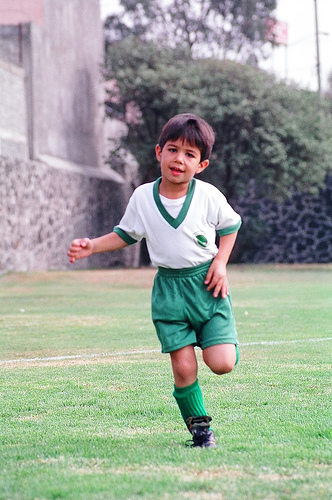

In [ ]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 16
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [ ]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(32360, 32360, 8095, 8095)

In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [ ]:
import tensorflow as tf

def CNN_Encoder():
    vgg16 = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet'
    )

    vgg16.trainable = False

    output = vgg16.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1])
    )(output)

    cnn_model = tf.keras.models.Model(vgg16.input, output)

    return cnn_model


In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [ ]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [ ]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([32, 40, 512])

In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [ ]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [ ]:
# history = caption_model.fit(
#     train_dataset,
#     epochs=15,
#     validation_data=val_dataset,
#     callbacks=[early_stopping]
# )

Epoch 1/15
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 484s 473ms/step - acc: 0.3803 - loss: 3.0528 - val_acc: 0.3553 - val_loss: 3.4655
Epoch 2/15
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 480s 471ms/step - acc: 0.3885 - loss: 2.9867 - val_acc: 0.3558 - val_loss: 3.4666
Epoch 3/15
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 481s 473ms/step - acc: 0.3966 - loss: 2.8963 - val_acc: 0.3573 - val_loss: 3.4789
Epoch 4/15
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 480s 471ms/step - acc: 0.4034 - loss: 2.8187 - val_acc: 0.3594 - val_loss: 3.4795


In [ ]:
# # after training — save the vocabulary used by the TextVectorization you trained
# vocab = tokenizer.get_vocabulary()    # list of tokens in index order
# save_path_toke = os.path.join(BASE, "tokenizer_vocab.json")
# with open(save_path_toke, "w", encoding="utf-8") as f:
#     json.dump(vocab, f, ensure_ascii=False)


In [ ]:
idx2word(2).numpy().decode('utf-8')

'a'

In [ ]:

def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.0
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: a man in a red shirt and white shirt is standing in front of a crowd



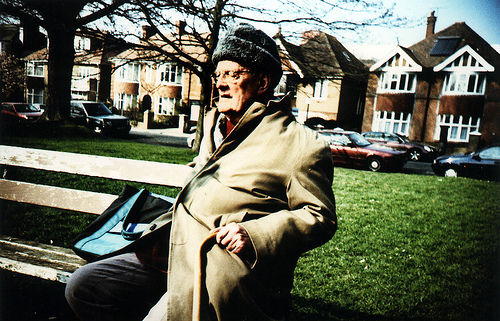

In [ ]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

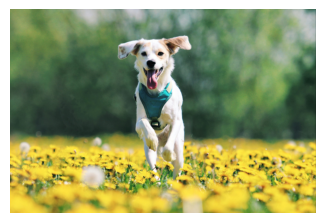

Predicted Caption: a dog runs through the grass


In [ ]:
url= "https://images.unsplash.com/photo-1679067652135-324b9535d288?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZG9nJTIwcnVubmluZ3xlbnwwfHwwfHx8MA%3D%3D&fm=jpg&q=60&w=3000"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

fig = plt.figure(figsize=(10/2.54, 10/2.54))  # convert cm → inches
plt.imshow(im)
plt.axis('off')  # hide axes
plt.show()
pred_caption = generate_caption('tmp.jpg')
print('Predicted Caption:', pred_caption)

In [ ]:
# save_path_trans_full = os.path.join(BASE, "transformer_saved_model_full.keras")
# caption_model.save(save_path_trans_full)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


# Testing

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
VOCABULARY_SIZE = 10000

saved_vocab_path = f"{BASE}/tokenizer_vocab.json"
with open(saved_vocab_path, "r", encoding="utf-8") as f:
    saved_vocab = json.load(f)

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,                # matches how you preprocessed training captions
    output_sequence_length=MAX_LENGTH,
    output_mode="int"
)

tokenizer.set_vocabulary(saved_vocab)

print("vocab length restored:", len(tokenizer.get_vocabulary()))


vocab length restored: 8832


In [ ]:
vocab_size = len(saved_vocab)
print("vocab_size:", vocab_size)

encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)
cnn_model = CNN_Encoder()

caption_model_test = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=None)


vocab_size: 8832


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_model=None, encoder=None, decoder=None, image_aug=None, **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug

    def call(self, imgs, captions=None, training=False):
        img_embed = self.cnn_model(imgs, training=training)
        enc = self.encoder(img_embed, training=training)
        if captions is None:
            return enc
        mask = tf.cast(captions != 0, tf.int32)
        logits = self.decoder(captions, enc, training=training, mask=mask)
        return logits

caption_model_test = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=None)
_dummy_img = tf.zeros((1,299,299,3), dtype=tf.float32)
_dummy_caption = tf.zeros((1, MAX_LENGTH), dtype=tf.int32)
_ = caption_model_test(_dummy_img, _dummy_caption, training=False)


In [ ]:
caption_model_test.load_weights(f"{BASE}/transformer_saved_model_full.keras")

In [ ]:
vocab = tokenizer.get_vocabulary()

def idx_to_token(idx):
    return vocab[int(idx)]

def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.0
    return img

def generate_caption_inference(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model_test.cnn_model(img)
    img_encoded = caption_model_test.encoder(img_embed, training=False)

    y_inp = "[start]"
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        preds = caption_model_test.decoder(tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(preds[0, i, :])
        pred_word = idx_to_token(pred_idx)

        if pred_word == "[end]":
            break

        if pred_word and pred_word != "":
            y_inp += " " + pred_word

    return y_inp.replace("[start] ", "").strip()


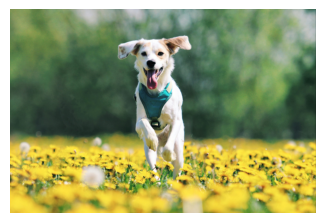

Predicted Caption: a dog runs through the grass


In [ ]:
url ="https://images.unsplash.com/photo-1679067652135-324b9535d288?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZG9nJTIwcnVubmluZ3xlbnwwfHwwfHx8MA%3D%3D&fm=jpg&q=60&w=3000"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

fig = plt.figure(figsize=(10/2.54, 10/2.54))  # convert cm → inches
plt.imshow(im)
plt.axis('off')  # hide axes
plt.show()
pred_caption = generate_caption_inference('tmp.jpg')
print('Predicted Caption:', pred_caption)

# **Part 2: hastag generation**

### a) using NLTK

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

def extract_keywords(content):
    tokens = nltk.word_tokenize(content)
    tags = nltk.pos_tag(tokens)

    keywords = [word for (word, tag) in tags if tag.startswith('NN') or tag == 'JJ' or tag == 'NNP']
    return keywords

def generate_hashtags(keywords):
    hashtags = ['#' + keyword.strip().replace(' ', '') for keyword in keywords]
    return hashtags

content = pred_caption

keywords = extract_keywords(content)
hashtags = generate_hashtags(keywords)


print("\nGenerated hashtags:")
print(", ".join(hashtags))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.



Generated hashtags:
#dog, #grass


In [ ]:
print(hashtags)

['#dog', '#grass']


In [ ]:
english_sentences = hashtags


# **Part 3: English to Regional Language**

### a) In English

In [ ]:
print(hashtags)

['#dog', '#grass']


# b) **In Hindi, Telegu, Tamil, Bengali**

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import nltk, json

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

def extract_keywords(content):
    tokens = nltk.word_tokenize(content)
    tags = nltk.pos_tag(tokens)
    keywords = [word for (word, tag) in tags if tag.startswith('NN') or tag == 'JJ' or tag == 'NNP']
    keywords = [word for word in keywords if len(word.strip()) > 2]
    return keywords

def generate_hashtags(keywords):
    hashtags = ['#' + word.strip().replace(' ', '') for word in keywords]
    return hashtags

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-one-to-many-mmt", src_lang="en_XX")

article_en =  pred_caption

langs = ["hi_IN", "te_IN", "bn_IN", "ta_IN"]

translations_dict = {}

en_keywords = extract_keywords(article_en)
en_hashtags = generate_hashtags(en_keywords)
translations_dict["en_XX"] = {
    "caption": article_en,
    "hashtag": ", ".join(en_hashtags)
}

for lang in langs:
    model_inputs = tokenizer(article_en, return_tensors="pt")
    generated_tokens = model.generate(
        **model_inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[lang]
    )

    caption = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    keywords = extract_keywords(caption)
    hashtags = generate_hashtags(keywords)

    translations_dict[lang] = {
        "caption": caption,
        "hashtag": ", ".join(hashtags)
    }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

In [ ]:

print(json.dumps(translations_dict, indent=2, ensure_ascii=False))

{
  "en_XX": {
    "caption": "a dog runs through the grass",
    "hashtag": "#dog, #grass"
  },
  "hi_IN": {
    "caption": "एक कुत्ता घास में दौड़ता है",
    "hashtag": "#कुत्ता, #घास, #में, #दौड़ता"
  },
  "te_IN": {
    "caption": "ఒక కుక్క గడ్డి ద్వారా నడుస్తాడు",
    "hashtag": "#కుక్క, #గడ్డి, #ద్వారా, #నడుస్తాడు"
  },
  "bn_IN": {
    "caption": "একটা কুকুর পাখিদের মধে ্ য দৌড়ে বেড়াচ ্ ছে",
    "hashtag": "#একটা, #কুকুর, #পাখিদের, #মধে, #দৌড়ে, #বেড়াচ"
  },
  "ta_IN": {
    "caption": "ஒரு நாய் புல்வெளியில் ஓடுகிறது.",
    "hashtag": "#ஒரு, #நாய், #புல்வெளியில், #ஓடுகிறது"
  }
}
